In [1]:
# PyTorch for implementing LLM (No GPU)
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request

In [2]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

using tinyshakespeare dataset, retrieved from karpathy github

In [3]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x1f7456e42d0>)

get de vocabulary size 

In [4]:
# Read the content of the dataset
lines = open("tinyshakespeare.txt", 'r').read()

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

MASTER_CONFIG.update({
    'vocab_size': len(vocab),
})

Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total number of characters in our dataset (Vocabulary Size): 65


create a dictionary to map characters to indices and vice versa

In [5]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

 create encode and decode functions that we’ll later apply to our dataset

In [6]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

make a tensor out of the dataset using torch

In [7]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([1115394])


data splitting 

In [8]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train_split = int(.8 * len(data))
    # Split the dataset into training, validation, and test sets
    train = data[:train_split]
    val = data[train_split: int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

In [9]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16      # Number of characters in each input (x) and target (y) sequence of each batch
})

print a random sample from the train split of batch 8 and context window 16 from our dataset:

In [10]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('ent the properti', 'nt the propertie'), (' toward him; the', 'toward him; ther'), ('zen:\nUp, sir, go', 'en:\nUp, sir, go '), ('ARIS:\nPoor soul,', 'RIS:\nPoor soul, '), ('And cowardly nob', 'nd cowardly nobl'), ('f fearful advers', ' fearful adversa'), ('ARGARET:\nAy, tho', 'RGARET:\nAy, thou'), ('t go:\nNay, but t', ' go:\nNay, but th')]


Evaluation strategy

In [11]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}
    
    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            
            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)
            
            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)
    
    # Set the model back to training mode
    model.train()
    
    return out

Base neural network model

In [12]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

         # Forward pass function for the base model
    def forward(self, idx, targets=None):
            # Embedding layer converts character indices to vectors
            x = self.embedding(idx)
            
            # Linear layers for modeling relationships between features
            a = self.linear(x)
            
            # Apply softmax activation to obtain probability distribution
            logits = F.softmax(a, dim=-1)

            # If targets are provided, calculate and return the cross-entropy loss
            if targets is not None:
                # Reshape logits and targets for cross-entropy calculation
                loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
                return logits, loss

            # If targets are not provided, return the logits
            else:
                return logits

        # Print the total number of model parameters
           

In [13]:
# Update MASTER_CONFIG with the dimension of linear layers (128)
MASTER_CONFIG.update({
    'd_model': 128,
})

# Instantiate the SimpleBrokenModel using the updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Print the total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))

Model parameters: 33217
Total number of parameters in the Simple Neural Network Model: 33217


In [14]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

In [15]:
# Update MASTER_CONFIG with training parameters
MASTER_CONFIG.update({
    'epochs': 1000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,        # Increase batch size to 32
})

# Instantiate the SimpleBrokenModel with updated configuration
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)

Model parameters: 33217


Validation loss:  3.944340443611145


<Axes: >

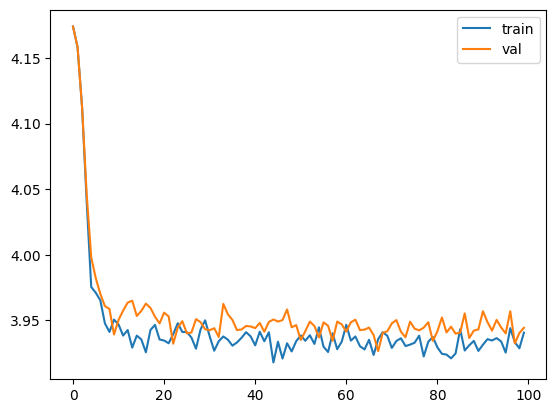

In [16]:
# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []
    
    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time
            
            # Evaluate loss on validation set
            x = evaluate_loss(model)
            
            # Store the validation loss
            losses += [x]
            
            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
                
            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])
    
    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
train(model, optimizer)

our model uses a softmax layer at the end to predict the next character. We’ll use the cross entropy loss function to train our model, taking advantage of F.cross_entropy function. the new base model class will be called SimpleModel

In [17]:
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

         # Forward pass function for the base model
    def forward(self, idx, targets=None):
            # Embedding layer converts character indices to vectors
            x = self.embedding(idx)
            
            # Linear layers for modeling relationships between features
            logits = self.linear(x)
            
            # If targets are provided, calculate and return the cross-entropy loss
            if targets is not None:
                # Reshape logits and targets for cross-entropy calculation
                loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
                return logits, loss

            # If targets are not provided, return the logits
            else:
                return logits

        # Print the total number of model parameters

Model parameters: 33217
Validation loss:  2.5384140014648438


<Axes: >

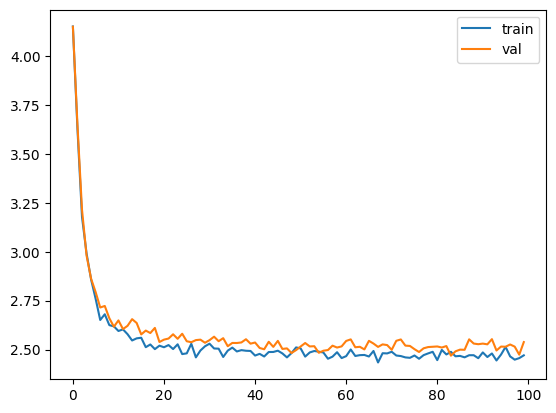

In [18]:
# Create the updated SimpleModel
model = SimpleModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model for 100 epochs
train(model, optimizer)   

let’s explore how our language model with approximately 33,000 parameters generates text during inferencing.

In [25]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\nA bu the. e m he wilool\nThat b',
 '\nALone mach a whe wo a\nAnon ma ',
 '\nN it hy p EEngesourelonila lye',
 '\n\n\nT:\nMENounthir.\nRI t lleliser',
 '\nWhey t:\nAnde ixprone,\nT:\nMas!\n']

## Replicate LLaMA Architecture

### RMSNorm for pre-normalization:

In [26]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [30]:
logits = torch.randn(1, 10, 5)
print("random logits: ", logits)
rms_norm = RMSNorm((10, 5))   
result = rms_norm(logits)
print("normalized logits: " ,result)

random logits:  tensor([[[ 1.0952, -0.0468,  0.2450, -0.4333,  0.1912],
         [-1.4924,  0.9524,  0.0851, -1.6127, -0.5229],
         [ 0.2366, -0.2725,  1.7694,  0.9516, -1.2124],
         [ 0.9782, -0.3568, -0.8091, -1.3310, -0.3223],
         [-0.7561,  0.9316,  0.1306,  0.2592, -1.0437],
         [-0.1755,  0.2181, -2.0128, -0.0882,  1.4416],
         [ 0.3333,  0.1442, -1.3154,  0.5945, -0.8109],
         [ 1.8688, -1.6763, -0.4675, -0.0373,  1.2872],
         [-0.8523,  0.9846, -0.1878,  1.7749,  0.6894],
         [-1.1947, -0.9121,  0.9393, -0.1612, -0.1878]]])
normalized logits:  tensor([[[ 1.1520, -0.0492,  0.2577, -0.4558,  0.2011],
         [-1.5698,  1.0017,  0.0895, -1.6963, -0.5500],
         [ 0.2488, -0.2866,  1.8611,  1.0009, -1.2752],
         [ 1.0289, -0.3753, -0.8511, -1.4000, -0.3390],
         [-0.7953,  0.9799,  0.1374,  0.2726, -1.0978],
         [-0.1846,  0.2294, -2.1171, -0.0928,  1.5163],
         [ 0.3506,  0.1517, -1.3836,  0.6253, -0.8530],
         [

Let's adapt our model to use RMSNorm

In [31]:
# Define the SimpleModel_RMS with RMSNorm
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Linear layers for modeling relationships between features
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )


        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # RMSNorm pre-normalization
        x = self.rms(x)

        # Linear layers for modeling relationships between features
        logits = self.linear(x)

        if targets is not None:
                # Reshape logits and targets for cross-entropy calculation
                loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
                return logits, loss

            # If targets are not provided, return the logits
        else:
            return logits

            



Let’s execute the modified NN model with RMSNorm and observe the updated number of parameters in the model, along with the loss:

Model parameters: 35265
Validation loss:  2.488813018798828


<Axes: >

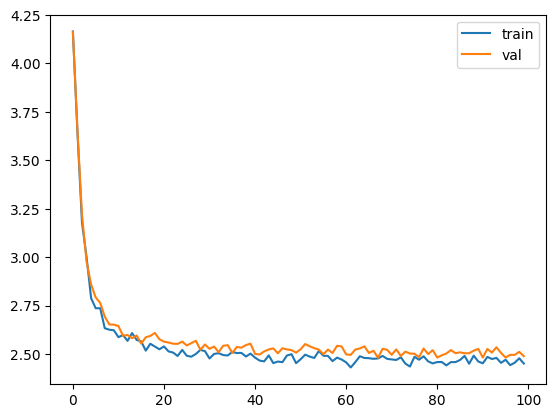

In [32]:
# Create an instance of SimpleModel_RMS
model = SimpleModel_RMS(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)